**The first step in detecting lane lines in images is camera calibration **

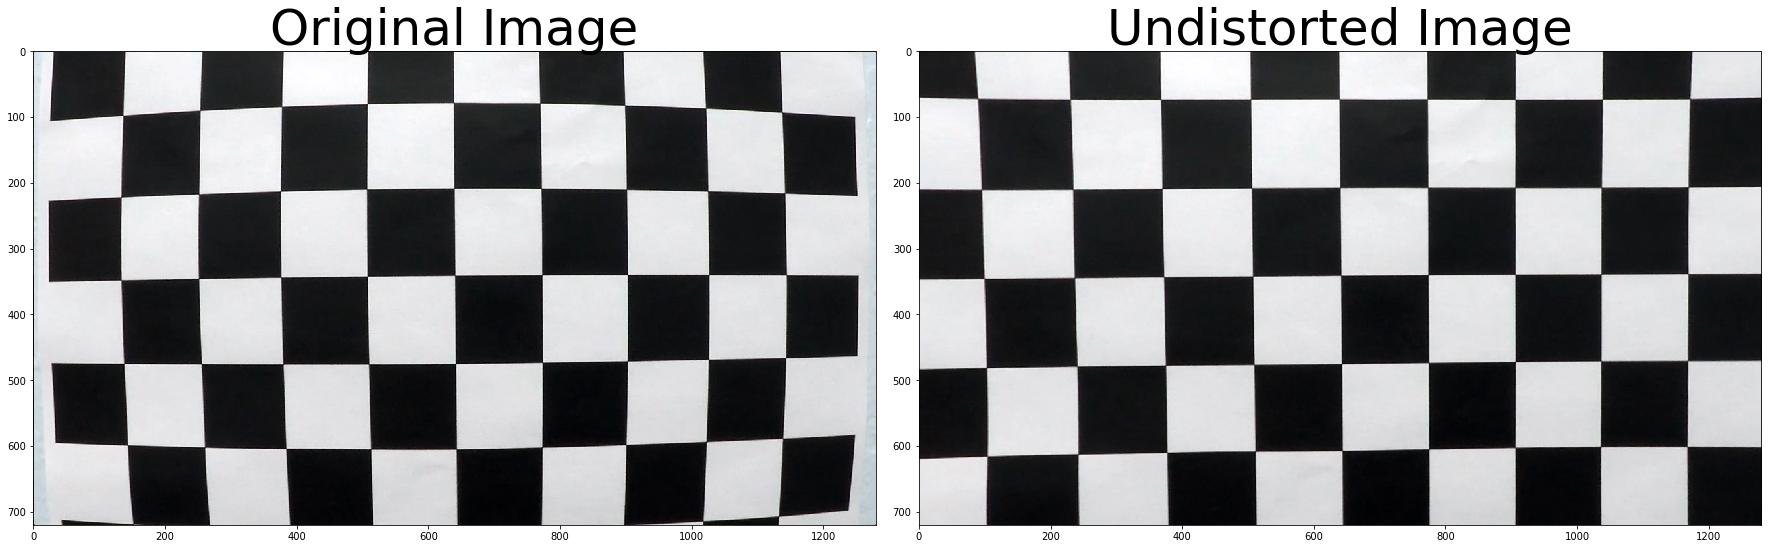

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

returned_list = []  
mtx_list =  []
dist_list =  []
rvecs_list =  []
tvecs_list = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


returned, mtx, dist, rvecs, tvecs =cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
img = cv2.imread('./camera_cal/calibration1.jpg')
undist =  cv2.undistort(img, mtx, dist, None,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



** Applying distortion correction on the test images**


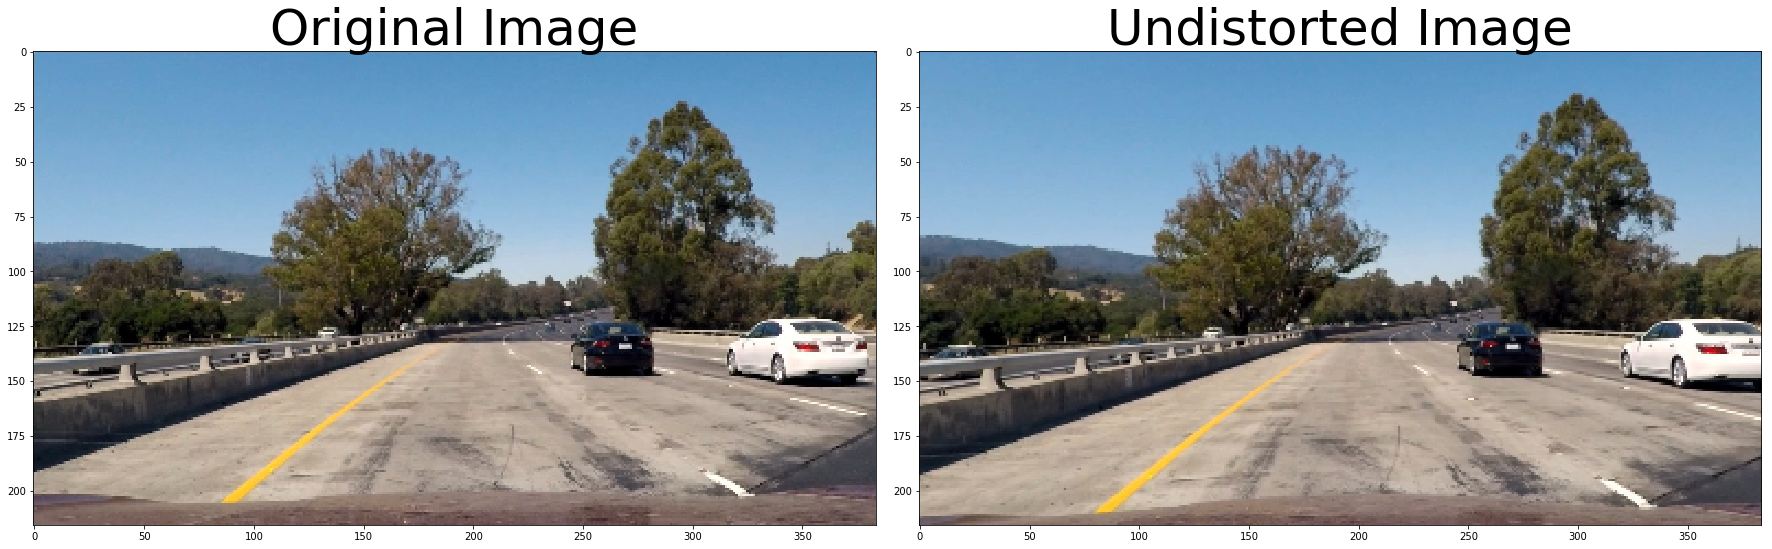

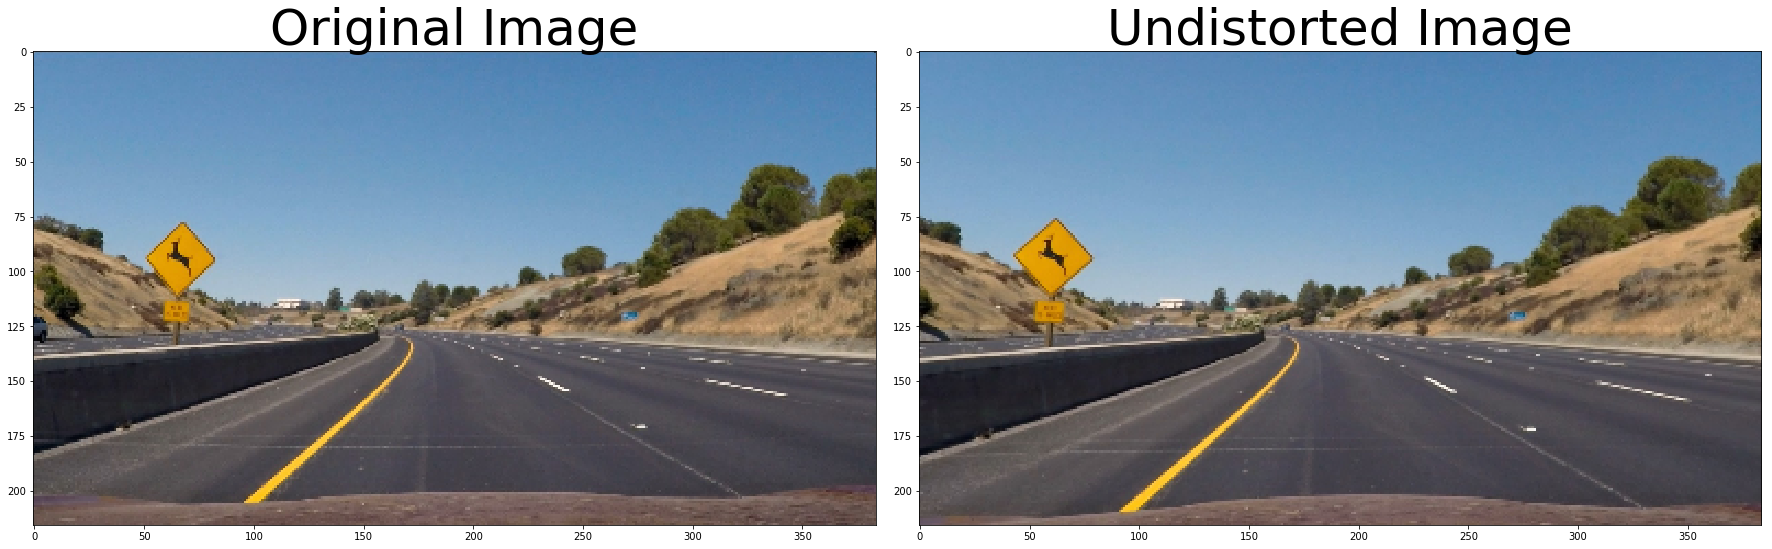

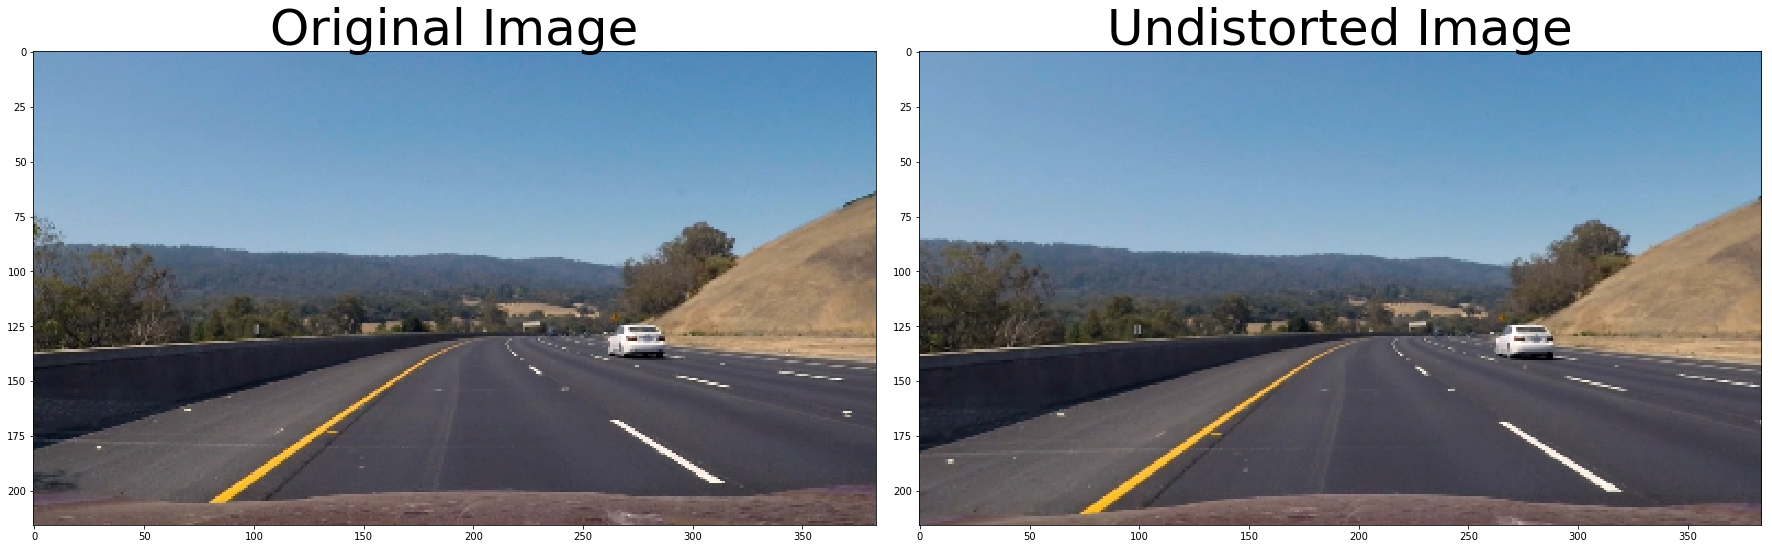

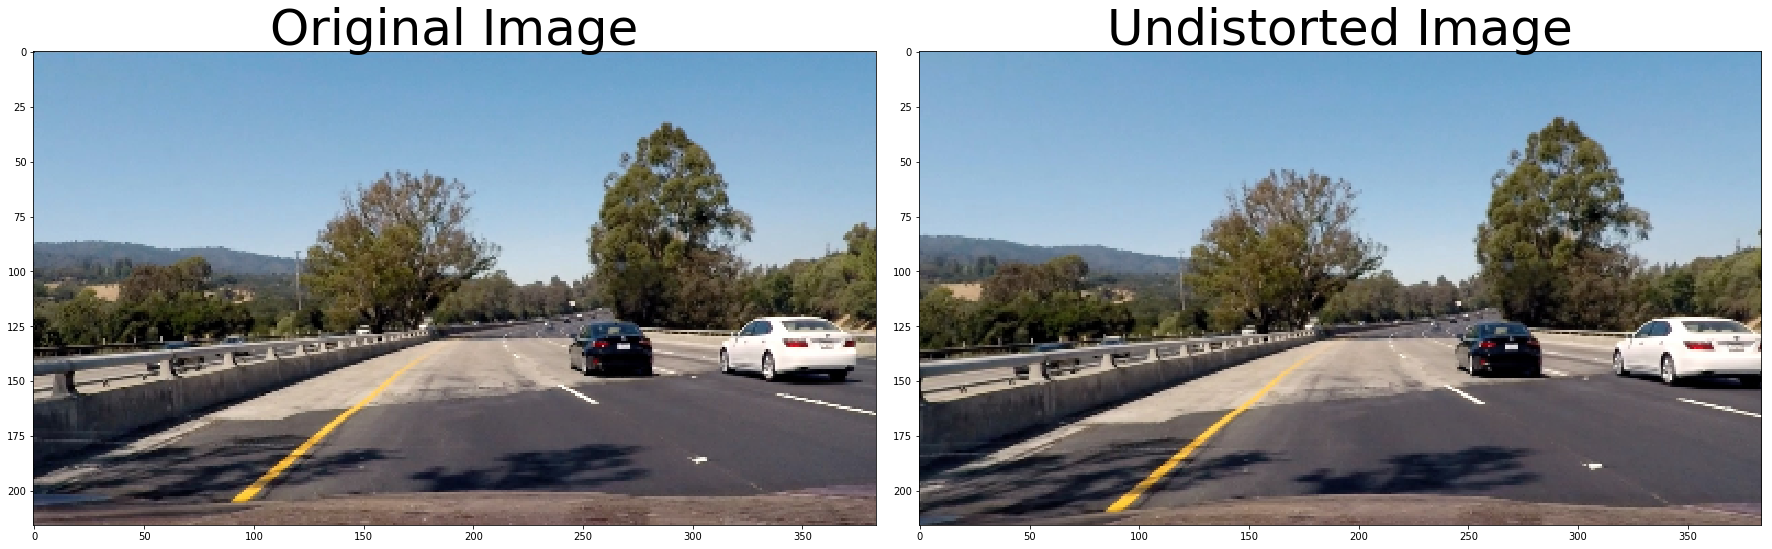

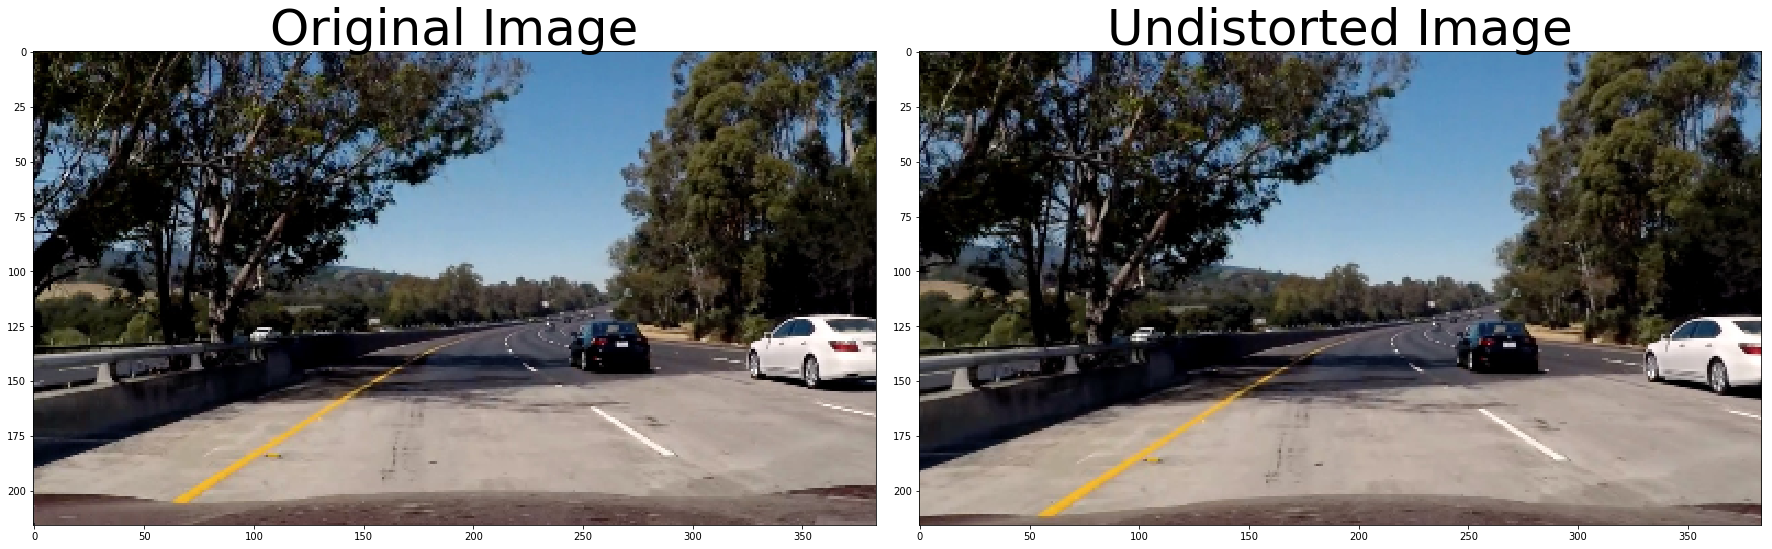

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [6]:
images = glob.glob('./test_images/test*')

for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    undist =  cv2.undistort(img, mtx, dist, None,mtx)
    undist = cv2.resize(undist, (0,0), fx=0.3, fy=0.3) 
    img = cv2.resize(img, (0,0), fx=0.3, fy=0.3) 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



***Applying perspective correction and thresholding to isolate lane markings...***

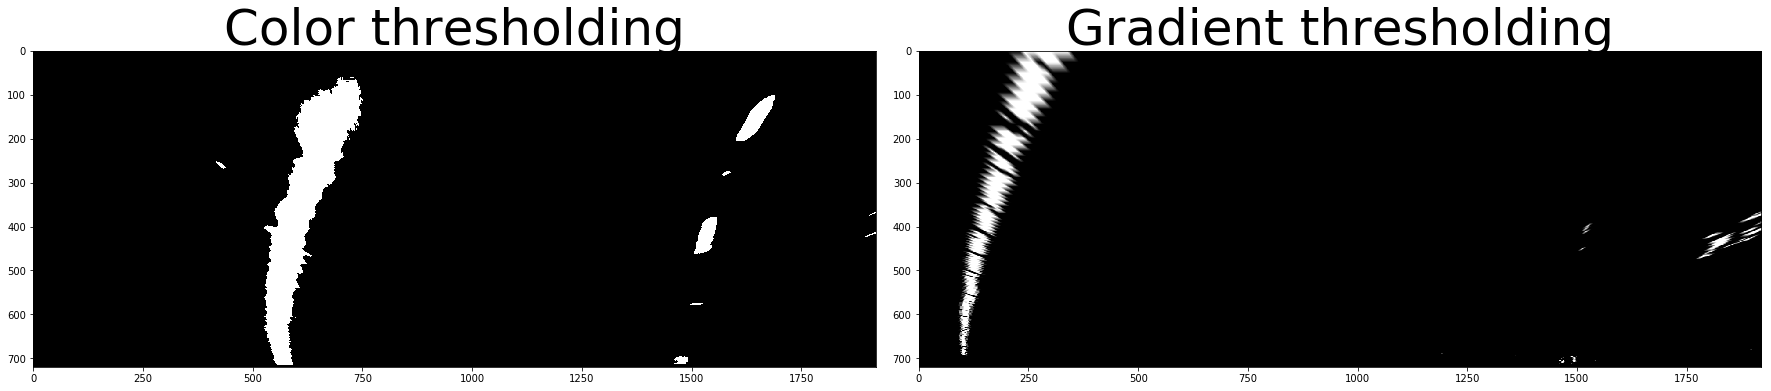

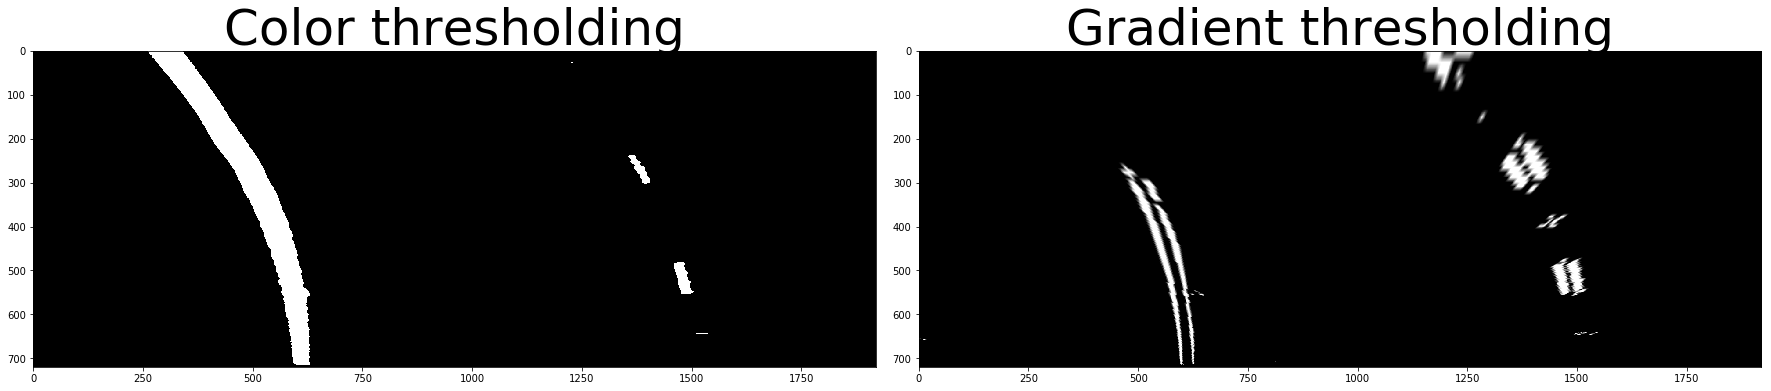

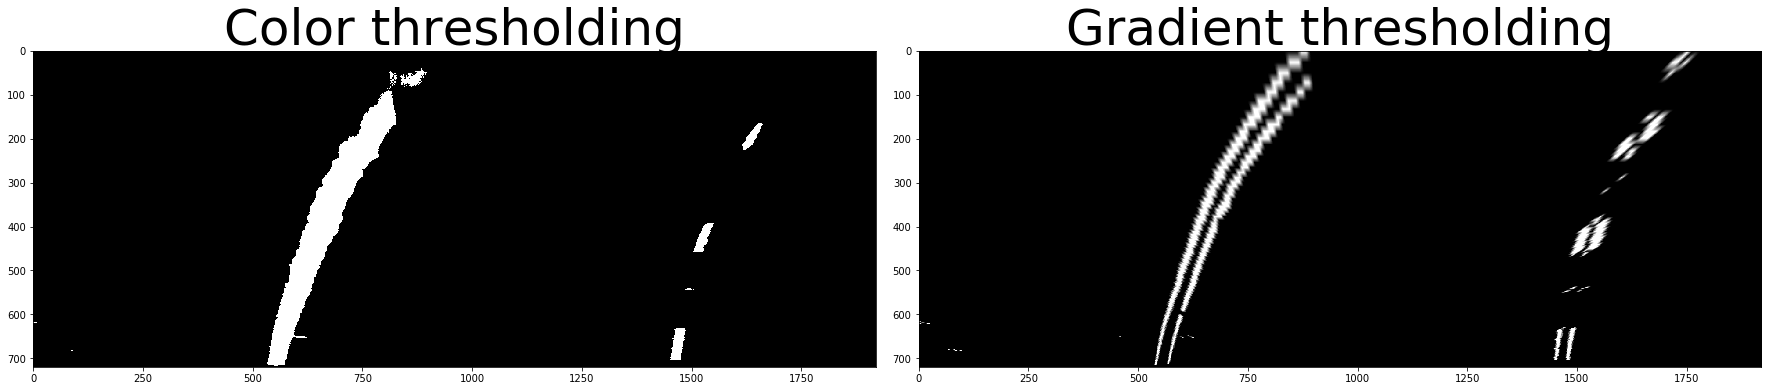

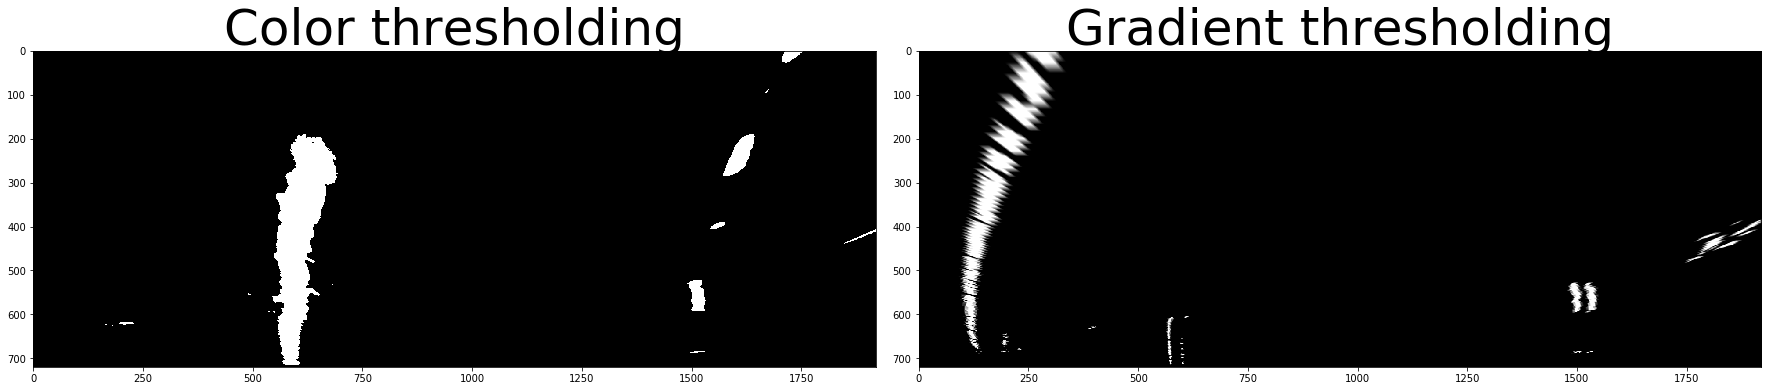

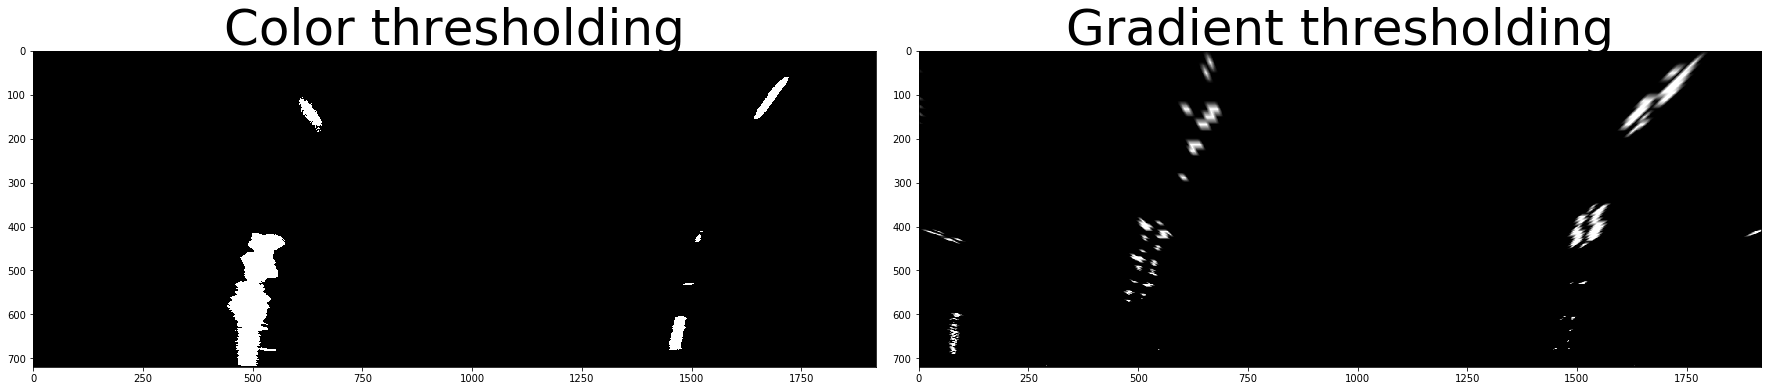

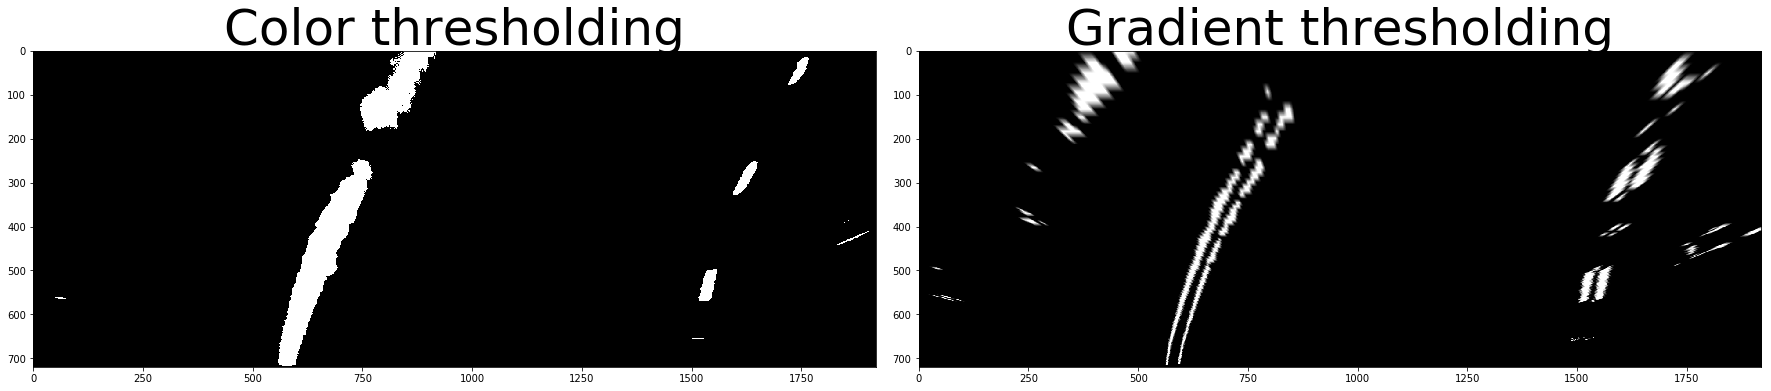

In [18]:
images = glob.glob('./test_images/test*')

##########################################
###### Gradient calculation
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[ (direction>thresh[0]) & (direction<thresh[1])] = 1
    return dir_binary

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

for fname in images:

    # Rectification of perspective
    image = cv2.imread(fname)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image =  cv2.undistort(image, mtx, dist, None,mtx)
    image = cv2.copyMakeBorder(image,0,0,320,320,cv2.BORDER_CONSTANT,value=(0,0,0))
    src = np.float32([[0,720],[863,450],[1057,450],[1920,720]])
    dst = np.float32([[0,720],[0,0],[1920,0],[1920,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped1 = cv2.warpPerspective(image, M, image[:,:,0].shape[::-1], flags=cv2.INTER_LINEAR)
    warped2 = cv2.warpPerspective(image, M, image[:,:,1].shape[::-1], flags=cv2.INTER_LINEAR)
    warped3 = cv2.warpPerspective(image, M, image[:,:,2].shape[::-1], flags=cv2.INTER_LINEAR)

    lab = cv2.cvtColor(warped3,cv2.COLOR_RGB2LAB)

    l = lab[:,:,0]
    b = lab[:,:,2]

    thresh_b = (145, 255)
    binary_b = np.zeros_like(b)
    binary_b[(b > thresh_b[0]) & (b <= thresh_b[1])] = 1

    thresh_l = (215, 255)
    binary_l = np.zeros_like(l)
    binary_l[(l > thresh_l[0]) & (l <= thresh_l[1])] = 1
    

    combined = cv2.max(binary_l,binary_b)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(70,230))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 230))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 230))
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.6,1.3))

    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    warped_grad = cv2.warpPerspective(combined_grad, M,combined_grad.shape[::-1], flags=cv2.INTER_LINEAR)
    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(combined,cmap='gray')
    ax1.set_title('Color thresholding', fontsize=50)
    ax2.imshow(warped_grad,cmap='gray')
    ax2.set_title('Gradient thresholding', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    



**Applying image processing  pipeline and plotting lane line curves**

(720, 0)

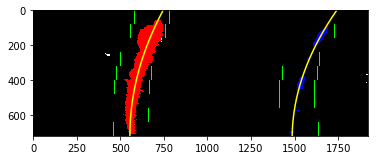

In [11]:

image = cv2.imread('./test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.copyMakeBorder(image,0,0,320,320,cv2.BORDER_CONSTANT,value=(0,0,0))
src = np.float32([[0,720],[863,450],[1057,450],[1920,720]])
dst = np.float32([[0,720],[0,0],[1920,0],[1920,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped1 = cv2.warpPerspective(image, M, image[:,:,0].shape[::-1], flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(image, M, image[:,:,1].shape[::-1], flags=cv2.INTER_LINEAR)
warped3 = cv2.warpPerspective(image, M, image[:,:,2].shape[::-1], flags=cv2.INTER_LINEAR)

lab = cv2.cvtColor(warped3,cv2.COLOR_RGB2LAB)
l = lab[:,:,0]
b = lab[:,:,2]

thresh_b = (145, 255)
binary_b = np.zeros_like(b)
binary_b[(b > thresh_b[0]) & (b <= thresh_b[1])] = 1

thresh_l = (215, 255)
binary_l = np.zeros_like(l)
binary_l[(l > thresh_l[0]) & (l <= thresh_l[1])] = 1

combined = cv2.max(binary_l,binary_b)


##################################################
######## fitting polynomial of lane ##############

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = combined
histogram = np.sum(binary_warped[  int(binary_warped.shape[0]/2) :,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 30
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1920)
plt.ylim(720, 0)

**Finding lane lines and restoring image to its original form and superimposing lane highlight... **

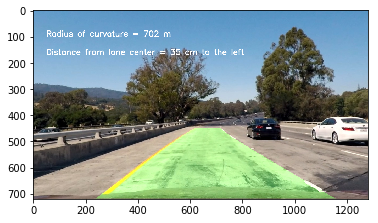

In [15]:

from moviepy.editor import VideoFileClip
%matplotlib inline


def process_image(image):
    
  
    global mtx
    global dist
    
    # Rectification of perspective
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image =  cv2.undistort(image, mtx, dist, None,mtx)
    image = cv2.copyMakeBorder(image,0,0,320,320,cv2.BORDER_CONSTANT,value=(0,0,0))
    src = np.float32([[0,720],[863,450],[1057,450],[1920,720]])
    dst = np.float32([[0,720],[0,0],[1920,0],[1920,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped1 = cv2.warpPerspective(image, M, image[:,:,0].shape[::-1], flags=cv2.INTER_LINEAR)
    warped2 = cv2.warpPerspective(image, M, image[:,:,1].shape[::-1], flags=cv2.INTER_LINEAR)
    warped3 = cv2.warpPerspective(image, M, image[:,:,2].shape[::-1], flags=cv2.INTER_LINEAR)

    r_channel = warped3[:,:,0]
    lab = cv2.cvtColor(warped3,cv2.COLOR_RGB2LAB)
    hls = cv2.cvtColor(warped3,cv2.COLOR_RGB2HLS)

    s = hls[:,:,2]
    l = lab[:,:,0]

    b = lab[:,:,2]

    thresh_b = (145, 255)
    binary_b = np.zeros_like(b)
    binary_b[(b > thresh_b[0]) & (b <= thresh_b[1])] = 1

    thresh_r = (220, 255)
    binary_r = np.zeros_like(s)
    binary_r[(r_channel > thresh_r[0]) & (r_channel <= thresh_r[1])] = 1

    thresh_s = (160, 255)
    binary_s = np.zeros_like(s)
    binary_s[(s > thresh_s[0]) & (s <= thresh_s[1])] = 1

    thresh_l = (215, 255)
    binary_l = np.zeros_like(l)
    binary_l[(l > thresh_l[0]) & (l <= thresh_l[1])] = 1

    combined = cv2.max(binary_l,binary_b)

    ##################################################
    ######## fitting polynomial of lane ##############

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    binary_warped = combined
    histogram = np.sum(binary_warped[  int(binary_warped.shape[0]/2) :,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    ################ Draw on the raw image #############
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cropped = result[:,320:1600].copy()
    ym_per_pix = 34/720 # meters per pixel in y dimension
    xm_per_pix = 3.5/900 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    offset = (((rightx_base + leftx_base)/2)-midpoint)*(3.7/900)*100
    avg = int( (left_curverad+right_curverad)/2 )
    offset = int(offset)
    # Now our radius of curvature is in meters
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(cropped,"Radius of curvature = {0} m".format(avg),(50,100),font,1,(255,255,255),2,cv2.LINE_AA)
    if(offset>=0 ):
        cv2.putText(cropped,"Distance from lane center = {0} cm to the left".format(offset),(50,170), font,1,(255,255,255),2,cv2.LINE_AA)
    else :
        offset = -1*offset
        cv2.putText(cropped,"Distance from lane center = {0} cm to the right".format(offset),(50,170), font,1,(255,255,255),2,cv2.LINE_AA)
       
   
    return cropped




# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

# If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Draw and display the corners
returned, mtx, dist, rvecs, tvecs =cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
image = cv2.imread('./test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
output_im = process_image(image)

plt.imshow(output_im)

